In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split

## Examine data

In [2]:
%%capture
df = pd.read_csv('clinvar_20180225.ann.tsv.gz', compression='gzip', sep='\t', error_bad_lines=False, header=0)

In [3]:
len(df)

372159

In [4]:
df.head()

,#id,chrom,inputPos,inputRef,inputAlt,unannotatedReason,gene,geneId,geneDesc,transcript,...,granthamDist,AGVGDclass,AGVGDgv,AGVGDgd,SIFTprediction,SIFTweight,SIFTmedian,MAPPprediction,MAPPpValue,MAPPpValueMedian
0,475283,1,949422,G,A,-,ISG15,4053,ISG15 ubiquitin-like modifier,NM_005101.3,...,46.0,C0,178.468,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,183381,1,949523,C,T,-,ISG15,4053,ISG15 ubiquitin-like modifier,NM_005101.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,475278,1,949597,C,T,-,ISG15,4053,ISG15 ubiquitin-like modifier,NM_005101.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,402986,1,949608,G,A,-,ISG15,4053,ISG15 ubiquitin-like modifier,NM_005101.3,...,46.0,C0,130.977,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,161455,1,949696,C,CG,-,ISG15,4053,ISG15 ubiquitin-like modifier,NM_005101.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df.dtypes

#id                       int64
chrom                    object
inputPos                  int64
inputRef                 object
inputAlt                 object
unannotatedReason        object
gene                     object
geneId                    int64
geneDesc                 object
transcript               object
strand                    int64
transLen                  int64
cdsLen                    int64
protein                  object
Uniprot                  object
varType                  object
codingEffect             object
varLocation              object
assembly                 object
gDNAstart                 int64
gDNAend                   int64
gNomen                   object
cDNAstart                object
cDNAend                  object
cNomen                   object
pNomen                   object
alt_pNomen               object
exon                      int64
intron                  float64
omimId                  float64
                         ...   
wtAA_3  

In [6]:
df.isnull().sum()

#id                          0
chrom                        0
inputPos                     0
inputRef                     0
inputAlt                     0
unannotatedReason            0
gene                         0
geneId                       0
geneDesc                     0
transcript                   0
strand                       0
transLen                     0
cdsLen                       0
protein                  16608
Uniprot                  88433
varType                      0
codingEffect            131716
varLocation                  0
assembly                     0
gDNAstart                    0
gDNAend                      0
gNomen                       0
cDNAstart                    0
cDNAend                      0
cNomen                       0
pNomen                    2380
alt_pNomen                2380
exon                         0
intron                  318115
omimId                   21182
                         ...  
wtAA_3                  158696
wtCodon 

## Preprocessing

### Filters

In [7]:
RELEVANT_FEATURES = [
    'chrom',
    'inputPos',
    'inputRef',
    'inputAlt',
    'transcript',
    'codingEffect',
    'varLocation',
    'alt_pNomen',
    'wtSSFScore',
    'wtMaxEntScore',
    'varSSFScore',
    'varMaxEntScore',
#     'rsId',
#     'rsClinicalSignificance',
    'rsMAF',
    '1000g_AF',
    'gnomadAltFreq_all',
    'espAllMAF',
    'espAllAAF',
    'clinVarMethods',
    'clinVarClinSignifs',
    'nOrthos',
    'conservedOrthos'
]


RULES = [
    lambda df: df['codingEffect'] != 'synonymous',
    lambda df: df['varLocation'] != 'intron',
    lambda df: np.invert(df['1000g_AF'] > 0.01),
    lambda df: np.invert(df['gnomadAltFreq_all'] > 0.01)
]


def rules_filter(df):
    for rule in RULES:
        df = df[rule(df)]
    return df


df = df[RELEVANT_FEATURES]  # Filtering relevant features
df = rules_filter(df)  # Rules filtering
df.reset_index(drop=True, inplace=True)
df.head()

,chrom,inputPos,inputRef,inputAlt,transcript,codingEffect,varLocation,alt_pNomen,wtSSFScore,wtMaxEntScore,...,varMaxEntScore,rsMAF,1000g_AF,gnomadAltFreq_all,espAllMAF,espAllAAF,clinVarMethods,clinVarClinSignifs,nOrthos,conservedOrthos
0,1,949422,G,A,NM_005101.3,missense,exon,p.Ser21Asn,80.7048,7.04863,...,7.04863,0.006190,0.006190,0.001599,0.005459,0.005459,NaN,NaN,10.0,2.0
1,1,949523,C,T,NM_005101.3,stop gain,exon,p.Gln55*,80.7048,7.04863,...,7.04863,0.000000,NaN,NaN,NaN,NaN,literature only,Pathogenic,NaN,NaN
2,1,949696,C,CG,NM_005101.3,frameshift,exon,p.Leu114Alafs*?,80.7048,7.04863,...,7.04863,0.000000,NaN,NaN,NaN,NaN,literature only,Pathogenic,NaN,NaN
3,1,949739,G,T,NM_005101.3,stop gain,exon,p.Glu127*,80.7048,7.04863,...,7.04863,0.000000,NaN,0.000008,NaN,NaN,literature only,Pathogenic,NaN,NaN
4,1,949851,G,C,NM_005101.3,missense,exon,p.Arg164Pro,80.7048,7.04863,...,7.04863,0.000799,0.000799,0.000265,0.000698,0.000698,NaN,NaN,10.0,2.0


### `inputPos` as regression parametr

In [8]:
df.inputPos = df.inputPos.astype(float)

### `clinVarMethods` split

In [9]:
CVM = df.clinVarMethods.fillna('NaN')
all_methods = set()
for s in CVM:
    all_methods.update(set(s.split('|')))
all_methods = {m: i for i, m in enumerate(list(all_methods))}

cvm_features = []
for s in CVM:
    s_features = np.zeros(len(all_methods))
    for s1 in s.split('|'):
        s_features[all_methods[s1]] += 1
    cvm_features.append(s_features)
cvm_features = np.vstack(cvm_features)

cvm_features = pd.DataFrame(cvm_features, columns=['cvm' + str(i) for i in range(len(all_methods))])
df = pd.concat([df, cvm_features], axis=1)
del df['clinVarMethods']
df.head()

,chrom,inputPos,inputRef,inputAlt,transcript,codingEffect,varLocation,alt_pNomen,wtSSFScore,wtMaxEntScore,...,cvm2,cvm3,cvm4,cvm5,cvm6,cvm7,cvm8,cvm9,cvm10,cvm11
0,1,949422.0,G,A,NM_005101.3,missense,exon,p.Ser21Asn,80.7048,7.04863,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,949523.0,C,T,NM_005101.3,stop gain,exon,p.Gln55*,80.7048,7.04863,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1,949696.0,C,CG,NM_005101.3,frameshift,exon,p.Leu114Alafs*?,80.7048,7.04863,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1,949739.0,G,T,NM_005101.3,stop gain,exon,p.Glu127*,80.7048,7.04863,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1,949851.0,G,C,NM_005101.3,missense,exon,p.Arg164Pro,80.7048,7.04863,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Making target

In [10]:
def pick_target(df, column='clinVarClinSignifs'):
    df = df.copy()
    df = df.loc[df[column].notna()]
    df.reset_index(drop=True, inplace=True)
    df['y'] = df[column].astype(str).apply(lambda x: int('pathogenic' in x.lower()))
    del df[column]
    return df

In [11]:
df = pick_target(df)
df.head()

,chrom,inputPos,inputRef,inputAlt,transcript,codingEffect,varLocation,alt_pNomen,wtSSFScore,wtMaxEntScore,...,cvm3,cvm4,cvm5,cvm6,cvm7,cvm8,cvm9,cvm10,cvm11,y
0,1,949523.0,C,T,NM_005101.3,stop gain,exon,p.Gln55*,80.7048,7.04863,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1
1,1,949696.0,C,CG,NM_005101.3,frameshift,exon,p.Leu114Alafs*?,80.7048,7.04863,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1
2,1,949739.0,G,T,NM_005101.3,stop gain,exon,p.Glu127*,80.7048,7.04863,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1
3,1,955563.0,G,C,NM_001305275.1,missense,exon,p.Arg4Pro,78.7671,9.04567,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
4,1,955596.0,C,G,NM_001305275.1,missense,exon,p.Pro15Arg,78.7671,9.04567,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0


## TT split

In [12]:
def tt_split(df):
    np.random.seed(42)
    df = df.copy()
    y = df.y
    del df['y']
    X = df
    cat_features = np.where(X.dtypes != np.float)[0]
    X = X.apply(lambda c: c.fillna('NaN') if (c.dtype == object) else c)
    X_, X_test, y_, y_test = train_test_split(X, y, test_size=0.2)
    X_train, X_validate, y_train, y_validate = train_test_split(X_, y_, test_size=0.2)
    return (X_train, y_train), (X_validate, y_validate), (X_test, y_test), cat_features

In [13]:
(X_train, y_train), (X_validate, y_validate), (X_test, y_test), cat_features = tt_split(df)
len(X_train), len(X_validate), len(X_test)

(128208, 32052, 40065)

## Run

In [14]:
model = CatBoostClassifier(iterations=500)

In [15]:
model.fit(X_train, y_train, cat_features=cat_features, 
          use_best_model=True, eval_set=(X_validate, y_validate));

0:	learn: 0.6668656	test: 0.6668698	best: 0.6668698 (0)	total: 320ms	remaining: 2m 39s
1:	learn: 0.6415417	test: 0.6414076	best: 0.6414076 (1)	total: 589ms	remaining: 2m 26s
2:	learn: 0.6139659	test: 0.6137001	best: 0.6137001 (2)	total: 809ms	remaining: 2m 14s
3:	learn: 0.5883516	test: 0.5871527	best: 0.5871527 (3)	total: 1.07s	remaining: 2m 12s
4:	learn: 0.5680755	test: 0.5667566	best: 0.5667566 (4)	total: 1.29s	remaining: 2m 7s
5:	learn: 0.5455033	test: 0.5435036	best: 0.5435036 (5)	total: 1.46s	remaining: 2m
6:	learn: 0.5255119	test: 0.5230671	best: 0.5230671 (6)	total: 1.71s	remaining: 2m
7:	learn: 0.5066989	test: 0.5040145	best: 0.5040145 (7)	total: 1.96s	remaining: 2m
8:	learn: 0.4898905	test: 0.4867691	best: 0.4867691 (8)	total: 2.16s	remaining: 1m 57s
9:	learn: 0.4717348	test: 0.4683023	best: 0.4683023 (9)	total: 2.33s	remaining: 1m 54s
10:	learn: 0.4569252	test: 0.4530618	best: 0.4530618 (10)	total: 2.48s	remaining: 1m 50s
11:	learn: 0.4426553	test: 0.4383815	best: 0.4383815 (

93:	learn: 0.2326535	test: 0.2223512	best: 0.2223512 (93)	total: 25.9s	remaining: 1m 51s
94:	learn: 0.2322395	test: 0.2219673	best: 0.2219673 (94)	total: 26.2s	remaining: 1m 51s
95:	learn: 0.2316416	test: 0.2213343	best: 0.2213343 (95)	total: 26.5s	remaining: 1m 51s
96:	learn: 0.2311576	test: 0.2208022	best: 0.2208022 (96)	total: 26.8s	remaining: 1m 51s
97:	learn: 0.2308158	test: 0.2204584	best: 0.2204584 (97)	total: 27.1s	remaining: 1m 51s
98:	learn: 0.2305780	test: 0.2202195	best: 0.2202195 (98)	total: 27.4s	remaining: 1m 50s
99:	learn: 0.2302644	test: 0.2198584	best: 0.2198584 (99)	total: 27.7s	remaining: 1m 50s
100:	learn: 0.2300259	test: 0.2196141	best: 0.2196141 (100)	total: 28s	remaining: 1m 50s
101:	learn: 0.2297116	test: 0.2193004	best: 0.2193004 (101)	total: 28.3s	remaining: 1m 50s
102:	learn: 0.2293627	test: 0.2189632	best: 0.2189632 (102)	total: 28.6s	remaining: 1m 50s
103:	learn: 0.2289609	test: 0.2186352	best: 0.2186352 (103)	total: 28.9s	remaining: 1m 49s
104:	learn: 0.2

184:	learn: 0.2095710	test: 0.1994868	best: 0.1994868 (184)	total: 55.2s	remaining: 1m 33s
185:	learn: 0.2094989	test: 0.1994320	best: 0.1994320 (185)	total: 55.5s	remaining: 1m 33s
186:	learn: 0.2094132	test: 0.1993624	best: 0.1993624 (186)	total: 55.8s	remaining: 1m 33s
187:	learn: 0.2093197	test: 0.1992931	best: 0.1992931 (187)	total: 56.1s	remaining: 1m 33s
188:	learn: 0.2091430	test: 0.1991001	best: 0.1991001 (188)	total: 56.3s	remaining: 1m 32s
189:	learn: 0.2089619	test: 0.1989538	best: 0.1989538 (189)	total: 56.6s	remaining: 1m 32s
190:	learn: 0.2088101	test: 0.1988472	best: 0.1988472 (190)	total: 56.9s	remaining: 1m 32s
191:	learn: 0.2087194	test: 0.1987672	best: 0.1987672 (191)	total: 57.2s	remaining: 1m 31s
192:	learn: 0.2084533	test: 0.1984791	best: 0.1984791 (192)	total: 57.6s	remaining: 1m 31s
193:	learn: 0.2082710	test: 0.1983064	best: 0.1983064 (193)	total: 58s	remaining: 1m 31s
194:	learn: 0.2080864	test: 0.1981318	best: 0.1981318 (194)	total: 58.3s	remaining: 1m 31s
1

274:	learn: 0.2008838	test: 0.1915836	best: 0.1915836 (274)	total: 1m 27s	remaining: 1m 11s
275:	learn: 0.2007632	test: 0.1914567	best: 0.1914567 (275)	total: 1m 28s	remaining: 1m 11s
276:	learn: 0.2007349	test: 0.1914394	best: 0.1914394 (276)	total: 1m 28s	remaining: 1m 11s
277:	learn: 0.2005440	test: 0.1912278	best: 0.1912278 (277)	total: 1m 29s	remaining: 1m 11s
278:	learn: 0.2004561	test: 0.1911414	best: 0.1911414 (278)	total: 1m 29s	remaining: 1m 10s
279:	learn: 0.2004175	test: 0.1911229	best: 0.1911229 (279)	total: 1m 29s	remaining: 1m 10s
280:	learn: 0.2003246	test: 0.1910238	best: 0.1910238 (280)	total: 1m 30s	remaining: 1m 10s
281:	learn: 0.2002796	test: 0.1909956	best: 0.1909956 (281)	total: 1m 30s	remaining: 1m 10s
282:	learn: 0.2002104	test: 0.1909451	best: 0.1909451 (282)	total: 1m 31s	remaining: 1m 9s
283:	learn: 0.2001454	test: 0.1908839	best: 0.1908839 (283)	total: 1m 31s	remaining: 1m 9s
284:	learn: 0.2001128	test: 0.1908605	best: 0.1908605 (284)	total: 1m 32s	remainin

365:	learn: 0.1959196	test: 0.1872474	best: 0.1872474 (365)	total: 1m 57s	remaining: 43.1s
366:	learn: 0.1958963	test: 0.1872257	best: 0.1872257 (366)	total: 1m 57s	remaining: 42.7s
367:	learn: 0.1958658	test: 0.1871987	best: 0.1871987 (367)	total: 1m 58s	remaining: 42.4s
368:	learn: 0.1958476	test: 0.1871866	best: 0.1871866 (368)	total: 1m 58s	remaining: 42.1s
369:	learn: 0.1958254	test: 0.1871657	best: 0.1871657 (369)	total: 1m 58s	remaining: 41.7s
370:	learn: 0.1957433	test: 0.1870811	best: 0.1870811 (370)	total: 1m 59s	remaining: 41.4s
371:	learn: 0.1956823	test: 0.1870208	best: 0.1870208 (371)	total: 1m 59s	remaining: 41.1s
372:	learn: 0.1956494	test: 0.1870071	best: 0.1870071 (372)	total: 1m 59s	remaining: 40.7s
373:	learn: 0.1956067	test: 0.1869837	best: 0.1869837 (373)	total: 1m 59s	remaining: 40.4s
374:	learn: 0.1955781	test: 0.1869529	best: 0.1869529 (374)	total: 2m	remaining: 40.1s
375:	learn: 0.1955438	test: 0.1869353	best: 0.1869353 (375)	total: 2m	remaining: 39.7s
376:	le

456:	learn: 0.1927193	test: 0.1847631	best: 0.1847631 (456)	total: 2m 26s	remaining: 13.8s
457:	learn: 0.1926936	test: 0.1847499	best: 0.1847499 (457)	total: 2m 26s	remaining: 13.5s
458:	learn: 0.1926835	test: 0.1847441	best: 0.1847441 (458)	total: 2m 27s	remaining: 13.2s
459:	learn: 0.1926544	test: 0.1847205	best: 0.1847205 (459)	total: 2m 27s	remaining: 12.8s
460:	learn: 0.1926177	test: 0.1846904	best: 0.1846904 (460)	total: 2m 28s	remaining: 12.5s
461:	learn: 0.1926044	test: 0.1846817	best: 0.1846817 (461)	total: 2m 28s	remaining: 12.2s
462:	learn: 0.1925984	test: 0.1846788	best: 0.1846788 (462)	total: 2m 28s	remaining: 11.9s
463:	learn: 0.1925112	test: 0.1845857	best: 0.1845857 (463)	total: 2m 29s	remaining: 11.6s
464:	learn: 0.1924418	test: 0.1845108	best: 0.1845108 (464)	total: 2m 29s	remaining: 11.3s
465:	learn: 0.1924310	test: 0.1845029	best: 0.1845029 (465)	total: 2m 29s	remaining: 10.9s
466:	learn: 0.1924215	test: 0.1844957	best: 0.1844957 (466)	total: 2m 30s	remaining: 10.6s

In [16]:
y_pred = model.predict(X_test)
(y_pred == y_test).sum() / len(y_test)

0.9272432297516535

In [17]:
def draw_importance(columns, importances):
    order = np.argsort(importances)
    
    objects = columns[order]
    y_pos = np.arange(len(objects))
    performance = np.array(importances)[order]

    plt.figure(figsize=(20, 10))
    plt.barh(y_pos, performance, align='center', alpha=0.5)
    plt.yticks(y_pos, objects)
    plt.xlabel('Importance')
    plt.title('Feature')

    plt.show()

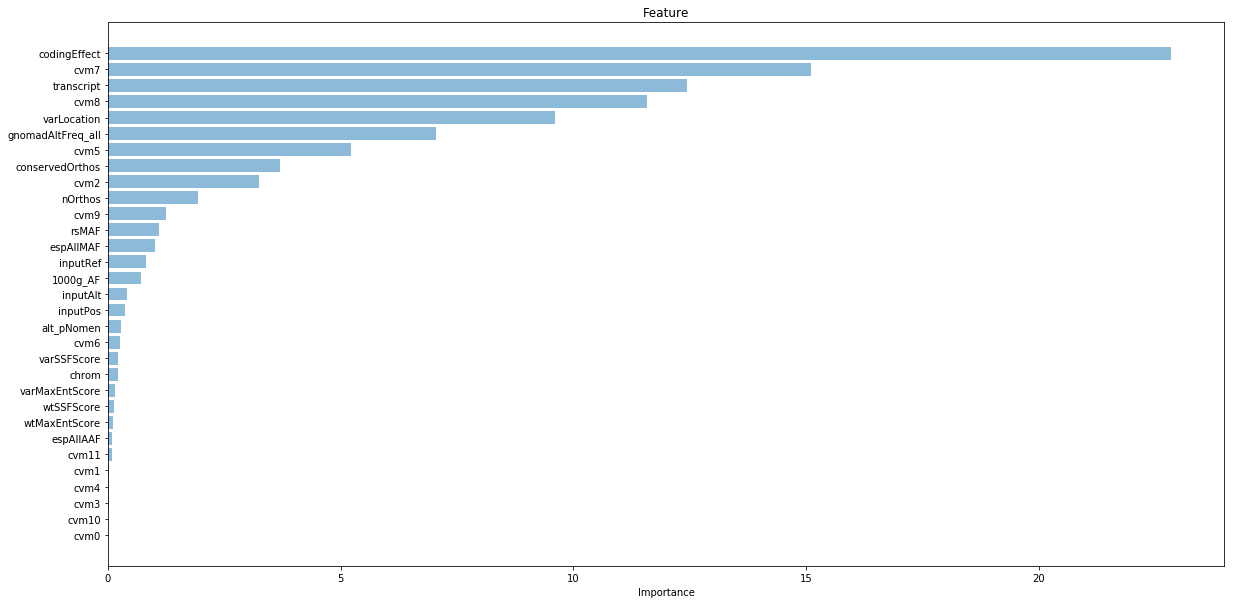

In [18]:
draw_importance(X_train.columns, model.feature_importances_)